# 23/01/2024 - Hand Gesture Recognition

---


# Setup


## Install Dependencies


In [43]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import libraries


In [44]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import os

In [45]:
tf.get_logger().setLevel("ERROR")

In [46]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16717), started 0:04:35 ago. (Use '!kill 16717' to kill it.)

# Data Preprocessing


In [48]:
DATASET_PATH = "./datasets/distance_and_angles_gestures_dataset.csv"

### Read CSV and split inputs from labels


In [49]:
from helpers.data import write_labels

dataset = pd.read_csv(DATASET_PATH)

print("is any NA in dataset ?", dataset.isna().any().any())
print("is any null in dataset ?", dataset.isnull().any().any())


labels = dataset["label"]
inputs = dataset.drop("label", axis=1)


inputs = inputs.to_numpy()
inputs = inputs.astype("float32")

X = inputs

dummies = pd.get_dummies(
    labels
)  # Creates a df of labels as categorical (ex : "closed" = [1, 0, 0, ..., 0])

classes = dummies.columns.to_list()
write_labels("./", classes)

labels = dummies.to_numpy()
labels = labels.astype("int64")


print(f"Input shape : {X[0].shape}")
print(f"Output shape : {labels[0].shape}")

is any NA in dataset ? False
is any null in dataset ? False
Input shape : (42,)
Output shape : (8,)


In [50]:
labels.shape

(93304, 8)

### Split data into training and testing sets


In [51]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)
print(f"Total dataset size : {len(X)}")
print("====================================")

print(f"Train dataset size : {len(x_train)}")
print(f"Test dataset size : {len(x_test)}")

Total dataset size : 93304
Train dataset size : 74643
Test dataset size : 18661


In [52]:
input_shape = X.shape[1]
output_shape = len(classes)
print(f"Input is of shape : {input_shape}")
print(f"Output is of shape : {output_shape}")

Input is of shape : 42
Output is of shape : 8


# Create the model


In [53]:
LOAD_MODEL = False
MODEL_LOAD_PATH = "./models"

LEARNING_RATE = 0.001
REGULARIZATION_RATE = 0.001
DROPOUT = 0.5

In [54]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from helpers.misc import get_model_name

model_name = ""


if LOAD_MODEL:
    model_name = MODEL_LOAD_PATH.split("/")[-1].split(".")[0]
    model = load_model(MODEL_LOAD_PATH)

else:
    model_name = get_model_name()

    regularizer = regularizers.l2(REGULARIZATION_RATE)

    model = Sequential(
        [
            Input(shape=[input_shape]),
            #
            Dense(32, activation="relu", kernel_regularizer=regularizer),
            # BatchNormalization(),
            # Dropout(rate=DROPOUT),
            #
            Dense(16, activation="relu", kernel_regularizer=regularizer),
            # BatchNormalization(),
            # Dropout(rate=DROPOUT),
            #
            Dense(units=output_shape, activation="softmax"),
        ]
    )

    optimizer = Adam(learning_rate=LEARNING_RATE)

    checkpointer_callback = ModelCheckpoint(
        filepath=f"models/{model_name}/{model_name}.hdf5",
        monitor="val_loss",
        verbose=False,
        save_best_only=True,
    )

    model.summary()

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1376      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
Total params: 2040 (7.97 KB)
Trainable params: 2040 (7.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20
)

In [56]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = (
    "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + " - " + model_name
)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [57]:
MODEL_METRICS_PATH = f"./models/{model_name}/training.log"

In [58]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger_callback = CSVLogger(MODEL_METRICS_PATH, separator=",", append=True)

In [59]:
os.makedirs(f"./models/{model_name}", exist_ok=True)

# Model Training


### Hyperparameters


In [60]:
SAVE_MODEL_PATH = f"./models/{model_name}"
LOAD_MODEL = False

NUM_EPOCHS = 1000

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 128
VERBOSE = 2

In [61]:
print(X.shape)
print(labels.shape)

(93304, 42)
(93304, 8)


In [62]:
from helpers.misc import get_timestamp

print(f"Training model {model_name}...\n")
start_time = time.time()


history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        checkpointer_callback,
        csv_logger_callback,
        # early_stopping_callback,
        tensorboard_callback,
    ],
)


training_duration = get_timestamp(time.time() - start_time)

print("\n-------------\n")
print("Training complete!")
print(f"Completed training in {training_duration}")

Training model NoearlyStopping...

Epoch 1/1000


467/467 - 1s - loss: 1.7907 - accuracy: 0.3492 - val_loss: 1.3825 - val_accuracy: 0.5488 - 1s/epoch - 2ms/step
Epoch 2/1000


/Users/louislecouturier/miniconda3/envs/kinected/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


467/467 - 0s - loss: 1.1569 - accuracy: 0.6731 - val_loss: 0.9867 - val_accuracy: 0.7620 - 387ms/epoch - 830us/step
Epoch 3/1000
467/467 - 0s - loss: 0.9183 - accuracy: 0.7915 - val_loss: 0.8125 - val_accuracy: 0.8222 - 347ms/epoch - 743us/step
Epoch 4/1000
467/467 - 0s - loss: 0.7798 - accuracy: 0.8376 - val_loss: 0.7199 - val_accuracy: 0.8436 - 338ms/epoch - 724us/step
Epoch 5/1000
467/467 - 0s - loss: 0.7123 - accuracy: 0.8577 - val_loss: 0.6724 - val_accuracy: 0.8623 - 337ms/epoch - 721us/step
Epoch 6/1000
467/467 - 0s - loss: 0.6750 - accuracy: 0.8645 - val_loss: 0.6400 - val_accuracy: 0.8739 - 325ms/epoch - 695us/step
Epoch 7/1000
467/467 - 0s - loss: 0.6504 - accuracy: 0.8701 - val_loss: 0.6195 - val_accuracy: 0.8792 - 322ms/epoch - 690us/step
Epoch 8/1000
467/467 - 0s - loss: 0.6295 - accuracy: 0.8750 - val_loss: 0.6013 - val_accuracy: 0.8800 - 320ms/epoch - 685us/step
Epoch 9/1000
467/467 - 0s - loss: 0.6144 - accuracy: 0.8772 - val_loss: 0.5925 - val_accuracy: 0.8720 - 323ms/

## Display model training metrics


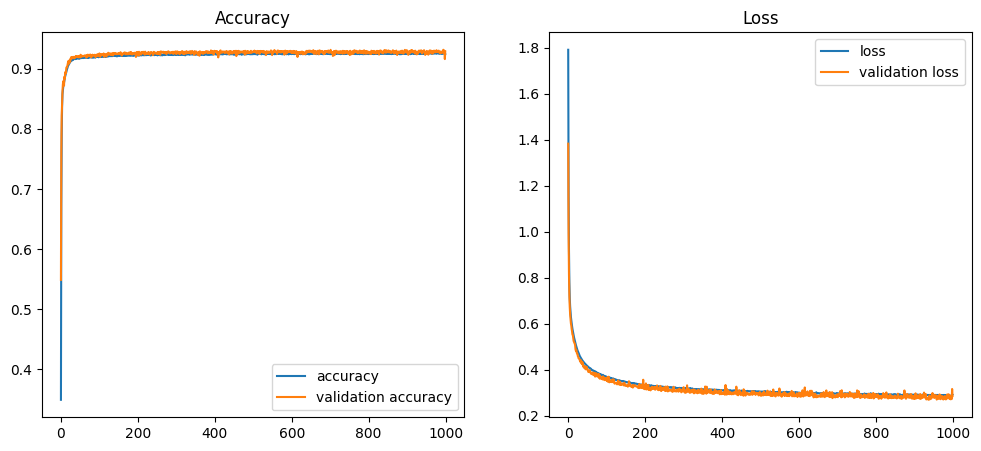

In [63]:
metrics = pd.read_csv(MODEL_METRICS_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(metrics["accuracy"], label="accuracy")
ax1.plot(metrics["val_accuracy"], label="validation accuracy")
ax1.set_title("Accuracy")

ax2.plot(metrics["loss"], label="loss")
ax2.plot(metrics["val_loss"], label="validation loss")
ax2.set_title("Loss")

ax1.legend()
ax2.legend()
plt.show()

## Evaluate the model


In [64]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)


print("\n")
print(f"Perte (Loss) sur l'ensemble de test : {loss}")
print(f"Précision (Accuracy) sur l'ensemble de test : {accuracy}")

584/584 - 0s - loss: 0.3033 - accuracy: 0.9244 - 280ms/epoch - 479us/step


Perte (Loss) sur l'ensemble de test : 0.3033256232738495
Précision (Accuracy) sur l'ensemble de test : 0.9244413375854492
